In [1]:
from edc import setup_environment_variables
setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `SH_CLIENT_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`, `SH_INSTANCE_ID`



In [2]:
from edc import check_compatibility
check_compatibility("user-0.22.3")

# NDWI Use Case

This notebook presents an example on how a user can exploit the xcube client library to access and analyse data served via Euro Data Cube service API.

Thematically, this notebook illustrates how to generate a timeline of NDWI values calculated from Sentinel-2 bands.

It demonstrates how xcube tools and Euro Data Cube complement each other. While Euro Data Cube services are used to access the data, xcube tools are utilized for analysis and visualization.

Specifically, following actions are demonstrated by this notebook:
1. Defining a new data cube for a given time range, region, and spatial resolution. 
2. Adding a new data layer to cube - calculated value of NDVI
3. Filling the cube with the data: requesting satellite imagery and calcualting NDWI layer
4. Displaying imageries, time series and linear plots for selected bands, area-of-interest and time

#### Importing dependancies
The user needs to first import the dependancies.

In [3]:
# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.viewer import ViewerServer

# xcube imports
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

# Various utilities
import json
from datetime import date, timedelta
import xarray as xr
import shapely.geometry
import IPython.display
import zarr
import numpy as np
import geopandas as gpd
import pandas as pd

To present the timeline of NDVI values, you will need to create a linear chart. 
 
To create the chart, it´s neccessary to import the Matplot library (matplotlib) first. The matplotlib is a plotting library which renders the plots.

In [4]:
import matplotlib.pyplot as plt

#### Specification of a geographical area of interest
The next step is to specify the area of interest - i.e. a geographical area, which the cube should cover and for which the NDVI will be calculated. 

The area of interest is specified via bounding box. You have to specify geographical coordinates of each corner of this bounding box.

For this demo, we are focussing on small coastal area near Kiel in Northern Germany (Baltic Sea).

In [5]:
bbox = 121.030334,14.168978,121.493134,14.547036
days = 30

 #### Visualisation of area of interest
 To check whether the area of interest has been specified correctly, you can integrate a simple map allowing visualisation of this area.

Visualize the bounding box.

In [6]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

 #### Setting the spatial resolution of the cube
 The next step is to specify the spatial resolution (pixel size) on which the raster data (in this case Sentinel-2 imageries) should be resampled and stored in.
 
In this case, the desired resolution is roughly 10 meters per pixel:


In [7]:
spatial_res = 0.00018   # = 10.038 meters in degree>

#### Configuring the data content of the cube
Now we specify the properties of our cube. 
First, the satellite and processing level of data to be integrated is specified. In this case, the Sentinel-2 Level 2A data will be used.

In the second row, the spectral bands are selected, which should be integarated. As we need to calculate NDVI index, we will need red and NIR bands (B04 and B08 of Sentinel-2).

Also, the time range and time period of the cube is specified in this step. In this case, we will be interested in data acquired between 14.5. and 31.7. 2018. A custom days time period will be used.

In [8]:
end_date = date(2018, 6, 28)
time_range = [(end_date - timedelta(days=days)).strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")]
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B03', 'B08'],
                         tile_size=[512, 512],
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=time_range,
                         time_period='5D')

#### Defining a "request collector"
We define a `request_collector` as an observer for SentinelHub (SH) requests made, so we can show SH usage statistics. 

In [9]:
request_collector = Observers.request_collector()

#### Loading data into the cube

Now, when the cube is correctly specified, we can open it. A lazy loading technique is used - it means that the data is loaded to the cube only when we actually use it (for some calcualtion, vizualization etc.). 

In [10]:
cube = open_cube(cube_config, observer=request_collector)

#### Verifying the content of the cube
Once the cube is opened, we can check whether it has been created in accordance with our expectations. 

The Cube Dataset information can be displayed, enabling to verify that the cube is specified correctly.

In [11]:
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 2560, lon: 3072, time: 7)
Coordinates:
  * lat        (lat) float64 14.63 14.63 14.63 14.63 ... 14.17 14.17 14.17 14.17
  * lon        (lon) float64 121.0 121.0 121.0 121.0 ... 121.6 121.6 121.6 121.6
  * time       (time) datetime64[ns] 2018-05-31T12:00:00 ... 2018-06-30T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(7, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-01-27T17:27:25.785647
    processing_level:          L2A
    time_coverage_start:       2018-05-29T00:00:00+00:00
    time_coverage_end:         2018-07-03T00:00:00+00:00
    time_coverage_duration:    P35DT0H0M0S
    time_coverage_resolution:  P5DT0H0M0S
    geospatial_lon_min:        121.030334
    geospatial_lat_min:        14.168978
    geospatial_lon_max:        121.583294
    geospatial_lat_max:        14.629778

No requests have been made yet. Requests are made only if data is actually required.

  
#### Displaying information on specific band in the cube
It is possible to check each band loaded into the cube separately. In this case, we will check the band 04 (RED) and then band 08 (NIR)


In [12]:
cube.B03

<xarray.DataArray 'B03' (time: 7, lat: 2560, lon: 3072)>
dask.array<xarray-B03, shape=(7, 2560, 3072), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 14.63 14.63 14.63 14.63 ... 14.17 14.17 14.17 14.17
  * lon      (lon) float64 121.0 121.0 121.0 121.0 ... 121.6 121.6 121.6 121.6
  * time     (time) datetime64[ns] 2018-05-31T12:00:00 ... 2018-06-30T12:00:00
Attributes:
    sample_type:   FLOAT32
    units:         reflectance
    wavelength:    559.4
    wavelength_a:  559.8
    wavelength_b:  559
    bandwidth:     36.0
    bandwidth_a:   36
    bandwidth_b:   36
    resolution:    10

In [13]:
cube.B08

<xarray.DataArray 'B08' (time: 7, lat: 2560, lon: 3072)>
dask.array<xarray-B08, shape=(7, 2560, 3072), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 14.63 14.63 14.63 14.63 ... 14.17 14.17 14.17 14.17
  * lon      (lon) float64 121.0 121.0 121.0 121.0 ... 121.6 121.6 121.6 121.6
  * time     (time) datetime64[ns] 2018-05-31T12:00:00 ... 2018-06-30T12:00:00
Attributes:
    sample_type:   FLOAT32
    units:         reflectance
    wavelength:    832.85
    wavelength_a:  832.8
    wavelength_b:  832.9
    bandwidth:     106.0
    bandwidth_a:   106
    bandwidth_b:   106
    resolution:    10

In [14]:
cube.B08.lon

<xarray.DataArray 'lon' (lon: 3072)>
array([121.030424, 121.030604, 121.030784, ..., 121.582844, 121.583024,
       121.583204])
Coordinates:
  * lon      (lon) float64 121.0 121.0 121.0 121.0 ... 121.6 121.6 121.6 121.6
Attributes:
    units:          decimal_degrees
    long_name:      longitude
    standard_name:  longitude

  
#### Displaying values for each time step in the time serie (band 03)
Once the cube is built and time serie generated, we can display the spectral values for each time step of the serie. 

For this example we'll select a point at latitude=54.40, longitude=10.1 inside our area of interest (or geographical extent of the cube).

In this case, the nearest-neighbor interpolation methods is used by xcube. Nearest neighbour interpolation is the simplest approach to interpolation. This method simply determines the “nearest” neighbouring pixel, and assumes the intensity value of it.


In [15]:
timeseriesB03 = cube.B03.sel(lat=14.629688, lon=121.030424, method='nearest').to_series()
timeseriesB03

time
2018-05-31 12:00:00    0.5264
2018-06-05 12:00:00       NaN
2018-06-10 12:00:00       NaN
2018-06-15 12:00:00       NaN
2018-06-20 12:00:00    0.6900
2018-06-25 12:00:00    0.1676
2018-06-30 12:00:00    0.9080
Name: B03, dtype: float32

  
#### Displaying values for each time step in the time serie in a linear plot (band 03)
Once the maplot library is imported, the same spectral values for each step of the time serie can be displayed also in a linear chart. 

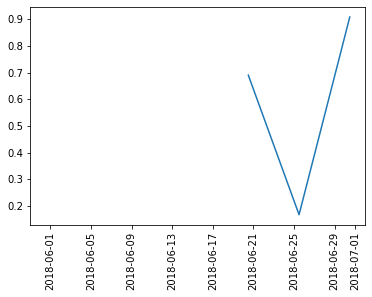

In [16]:
plt.plot(timeseriesB03)
plt.xticks(rotation='vertical')
plt.figsize=(15, 6)
plt.show()

The time serie can be plotted in a similar manner also for the band 08:

In [17]:
timeseriesB08 = cube.B08.sel(lat=14.629688, lon=121.030424, method='nearest').to_series()
timeseriesB08

time
2018-05-31 12:00:00    0.4787
2018-06-05 12:00:00       NaN
2018-06-10 12:00:00       NaN
2018-06-15 12:00:00       NaN
2018-06-20 12:00:00    0.6098
2018-06-25 12:00:00    0.2077
2018-06-30 12:00:00    0.8318
Name: B08, dtype: float32

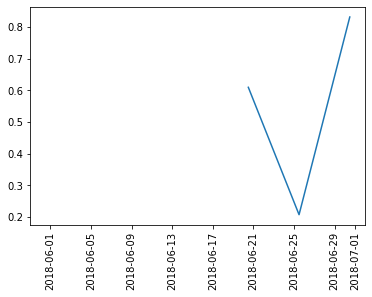

In [18]:
plt.plot(timeseriesB08)
plt.xticks(rotation='vertical')
plt.figsize=(15, 6)
plt.show()

#### Displaing cube data for selected band and time step as imageries

We can also display the data for any combination of selected spectral band and time step of the times serie contained in the cube as an imagery. We may need this to check the data visually, over entire area of interest (geographical extent of the cube).


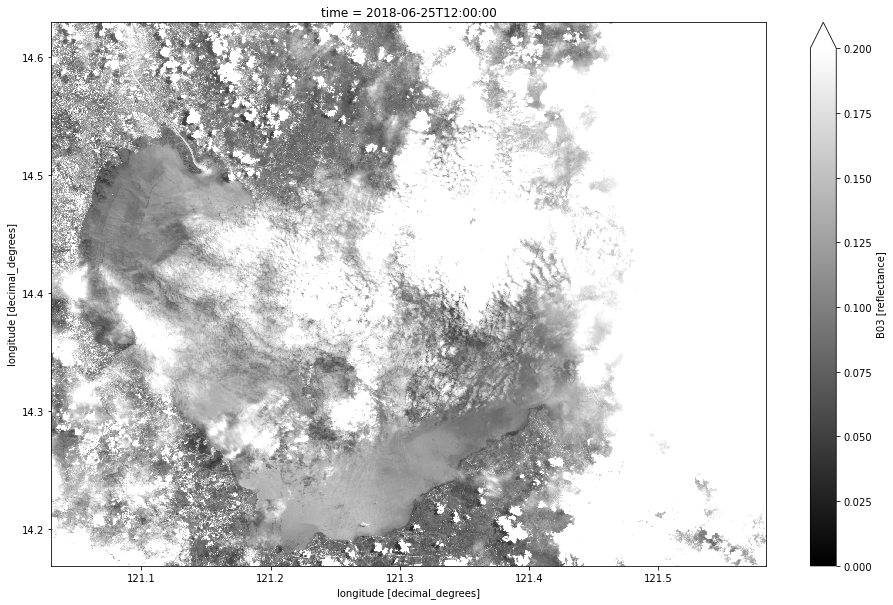

In [19]:
cube.B03.sel(time='2018-06-25 12:00:00', method='nearest').plot.imshow(vmin=0.0, vmax=0.2, cmap='gray', figsize=(16, 10))

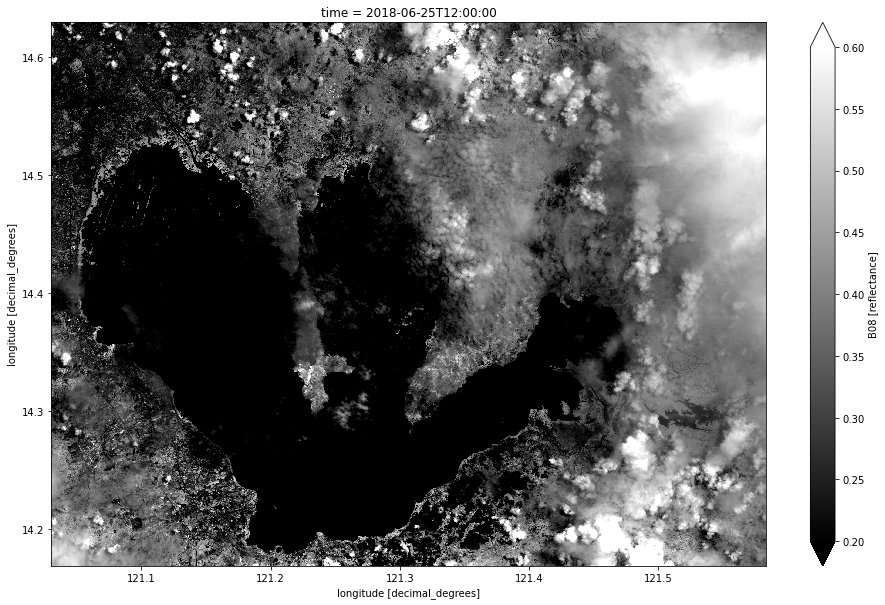

In [20]:
cube.B08.sel(time='2018-06-25 12:00:00', method='nearest').plot.imshow(vmin=0.2, vmax=0.6, cmap='gray', figsize=(16, 10))

#### Displaing statistics for SentinelHub request
Now SentinelHub data requests have been made. We can easilly display statistics on this request. 


In [21]:
request_collector.stats

Number of requests:,72
Request duration min:,120.23 ms
Request duration max:,864.02 ms
Request duration median:,458.83 ms
Request duration mean:,462.53 ms
Request duration std:,151.94 ms


There are two ways of selecting the area of interest:
* By masking - this keeps only the data of the WKT Polygon or shapefile
* By clipping - this creates a new bounding box, which ensures that the area of interest is within the subset but keeps the surrounding data (*this is commented out in the following cells*)

<AxesSubplot:>

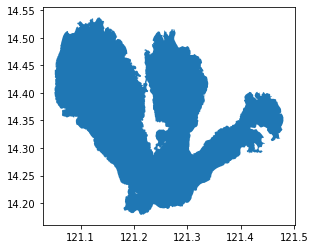

In [22]:
bay = gpd.read_file('laguna_de_bay.geojson')
bay.plot()

In [23]:
polygon = bay['geometry'][0]

In [24]:
cube_masked = mask_dataset_by_geometry(cube, geometry=polygon)
cube_masked

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 1995, lon: 2387, time: 7)
Coordinates:
  * lat        (lat) float64 14.54 14.54 14.54 14.54 ... 14.18 14.18 14.18 14.18
  * lon        (lon) float64 121.1 121.1 121.1 121.1 ... 121.5 121.5 121.5 121.5
  * time       (time) datetime64[ns] 2018-05-31T12:00:00 ... 2018-06-30T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(7, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 398), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 398), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.7
    title:                      S2L2A Data Cube Subset
    history:                    [{'program': 'xcube_sh.chunkstore.SentinelHub...
    date_created:               2021-01-27T17:27:25.785647
    processing_level:           L2A
    time_coverage_start:        2018-05-29T00:00:00+00:00
    time_coverage_end:          2018-07-03T00:00:00+00:00
    time_coverage_duration:     P35DT0H0M0S
    time_coverage_resolution:   P5DT0H0M0S
    geospatial_lon_min:         121.050854
    geospatial_lat_min:         14.178517999999999
    geospatial_lon_max:         121.480514
    geospatial_lat_max:         14.537618
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.0001799999999999992
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.0001800000000000006
    date_modified:              2021-01-27T17:28:01.977539

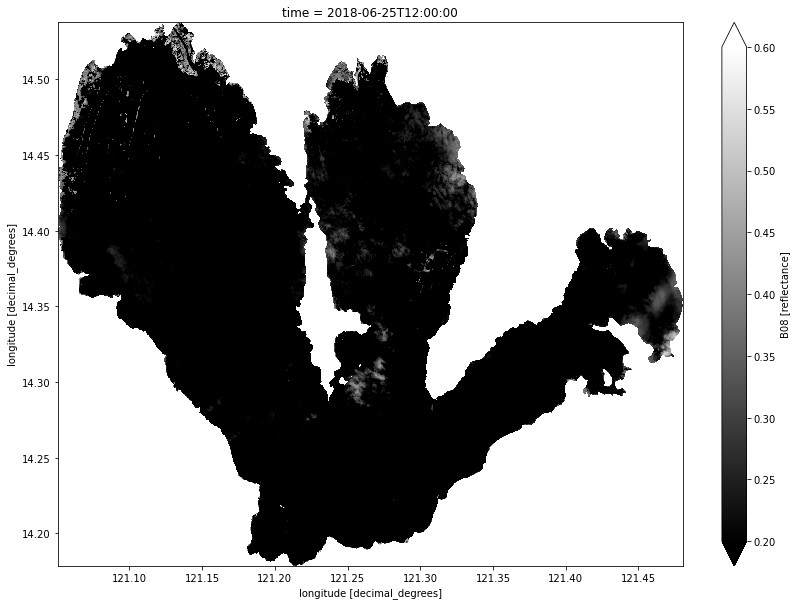

In [25]:
cube_masked.B08.sel(time='2018-06-25 12:00:00', method='nearest').plot.imshow(vmin=0.2, vmax=0.6, cmap='gray', figsize=(14, 10))

#### Preparing values for new NDWI layer
Now we will prepare values for the new NDWI layer, based on combination of the bands already contained in our cube.

In [26]:
ndwi=(cube_masked.B03-cube_masked.B08)/(cube_masked.B03+cube_masked.B08)

#### Specifying properties of new NDWI layer
We can also specify some properties of the new NDVI layer, which should be added into our cube - in this case, we set the "long name" and units of the layer.


In [27]:
ndwi.attrs['long_name']='Normalized Difference Water Index'
ndwi.attrs['units']='unitless'

#### Adding a new NDWI layer to cube
Now the values are calculated and the properties specified, we can easilly add the new NDVI layer into our cube.

In [28]:
cube_masked['NDWI']=ndwi

#### Displaying information for NDWI layer
Again, as in case of original bands 04 and 08, we can ceck the properties of the NDVI layer.

In [29]:
cube_masked.NDWI

<xarray.DataArray 'NDWI' (time: 7, lat: 1995, lon: 2387)>
dask.array<truediv, shape=(7, 1995, 2387), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 14.54 14.54 14.54 14.54 ... 14.18 14.18 14.18 14.18
  * lon      (lon) float64 121.1 121.1 121.1 121.1 ... 121.5 121.5 121.5 121.5
  * time     (time) datetime64[ns] 2018-05-31T12:00:00 ... 2018-06-30T12:00:00
Attributes:
    long_name:  Normalized Difference Water Index
    units:      unitless

#### Displayng time series of NDWI
Also, we can display time serie of values of NDVI band at selected location for all time steps.

For example we'll select the point at latitude=54.40, longitude=10.1
Nearest-neighbor interpolation is used by xcube to find closest satellite pixel at each time step.


In [30]:
timeseriesNDWI = cube_masked.NDWI.sel(lat=14.537348, lon=121.480064, method='nearest').to_series()
timeseriesNDWI

time
2018-05-31 12:00:00   NaN
2018-06-05 12:00:00   NaN
2018-06-10 12:00:00   NaN
2018-06-15 12:00:00   NaN
2018-06-20 12:00:00   NaN
2018-06-25 12:00:00   NaN
2018-06-30 12:00:00   NaN
Name: NDWI, dtype: float32

#### Displayng time series of NDWI in linear plot
Now, when we computed the NDVI values for each step in the time serie, we can easily display them in linear plot, as in case of original Sentinel-2 bands.


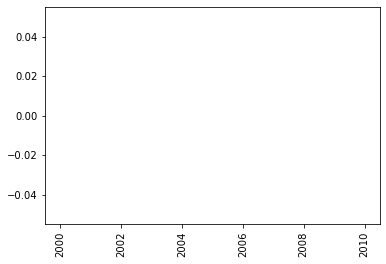

In [31]:
plt.plot(timeseriesNDWI)
plt.xticks(rotation='vertical')
plt.figsize=(15, 6)
plt.show()

#### Displaying NDWI at selected time step as image

To check the NDWI values over whole area of interest, we can display the NDVI values for any selected time step of the time serie as image in selected color scale. 
For example we'll select the time step 2018-06-25.

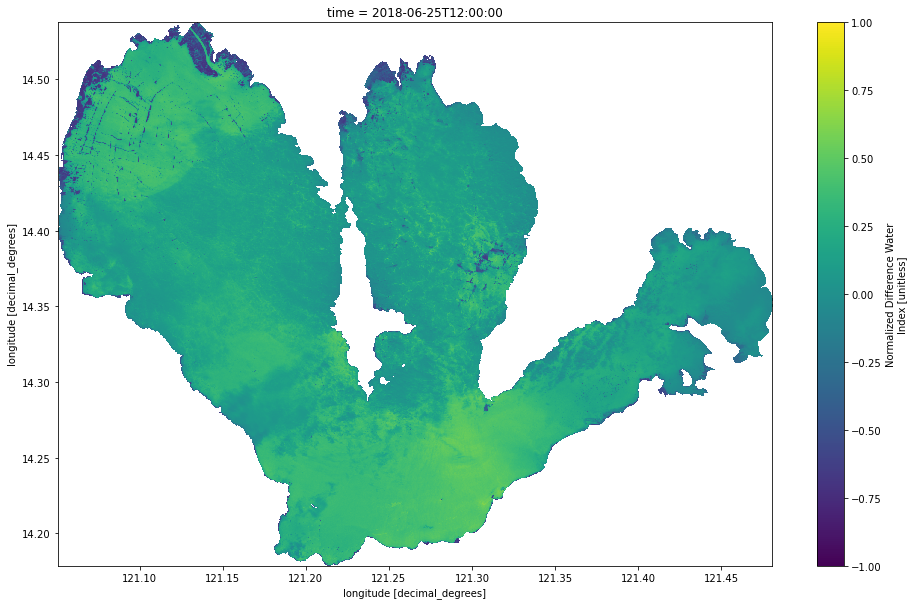

In [32]:
cube_masked.NDWI.sel(time='2018-06-25 12:00:00', method='nearest').plot.imshow(vmin=-1, vmax=1, cmap='viridis', figsize=(16, 10))
#cube.NDVI.sel(time='2018-06-25 10:00:00', method='nearest').plot.imshow(vmin=-1, vmax=1, cmap='RdYlGn', figsize=(16, 10))
#cube.NDVI.sel(time='2018-07-25 10:00:00', method='nearest').plot.imshow(vmin=-1, vmax=1, cmap='RdYlGn', figsize=(16, 10))

#### Displaying NDVI for all time steps in the serie as image

To check the NDVI values over whole area of interest for all time step in the time serie, 
we can display the NDVI values for all selected time steps of the serie as image in the same color scale beside each other. 
This allows us to visually compare the development of NDVI values over whole time serie and to compare various time steps with each other.

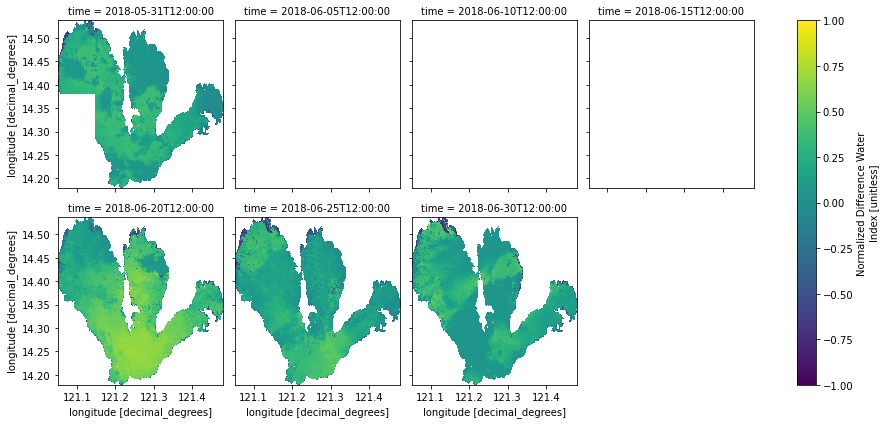

In [33]:
img=cube_masked.NDWI.plot.imshow(col='time', col_wrap=4, vmin=-1, vmax=1,cmap='viridis')

## Aggregating the data

Basic statistical measures can also be calculated per date

In [34]:
date = []
max_value = []
ave = []
min_value = []
stDev = []

for ndwi_date in cube_masked.NDWI:
    date.append(str(ndwi_date.time.values))
    max_value.append(ndwi_date.values.max())
    ave.append(ndwi_date.values.mean())
    min_value.append(ndwi_date.values.min())
    stDev.append(np.std(ndwi_date.values))
                
ndwi_df = pd.DataFrame({'date':date, 'min':min_value, 'max':max_value, 'mean':ave, 'stDev':stDev})
ndwi_df

,date,min,max,mean,stDev
0,2018-05-31T12:00:00.000000000,NaN,NaN,NaN,NaN
1,2018-06-05T12:00:00.000000000,NaN,NaN,NaN,NaN
2,2018-06-10T12:00:00.000000000,NaN,NaN,NaN,NaN
3,2018-06-15T12:00:00.000000000,NaN,NaN,NaN,NaN
4,2018-06-20T12:00:00.000000000,NaN,NaN,NaN,NaN
5,2018-06-25T12:00:00.000000000,NaN,NaN,NaN,NaN
6,2018-06-30T12:00:00.000000000,NaN,NaN,NaN,NaN
